In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import DatasetFolder
from datasets import load_metric

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc
from sklearn.preprocessing import label_binarize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
# Define the transformations
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(degrees=15),
    # transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.Lambda(lambda x: x.to(torch.float32))
])

root = '../dataset'

# Initialize DatasetFolder for train and validation datasets
train_dataset = DatasetFolder(
    root=os.path.join(root, 'train'),
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)
test_dataset = DatasetFolder(
    root=os.path.join(root, 'val'),
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)

# Split the train dataset to get the validation dataset
train_dataset, val_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.9), int(len(train_dataset) * 0.1)])

# Set the batch size
batch_size = 60

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print some information about the data
print(f'Train dataset size: {len(train_dataset)}')
print(f'Val dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')
print(f'Image shape: {train_dataset[0][0].shape}')
print(f'Classes: {train_dataset.dataset.classes}')
print(f'Image tensor type: {train_dataset[0][0].dtype}')
print(f'Batches: {len(train_loader)}')

Train dataset size: 27000
Val dataset size: 3000
Test dataset size: 7500
Image shape: torch.Size([1, 150, 150])
Classes: ['no', 'sphere', 'vort']
Image tensor type: torch.float32
Batches: 450


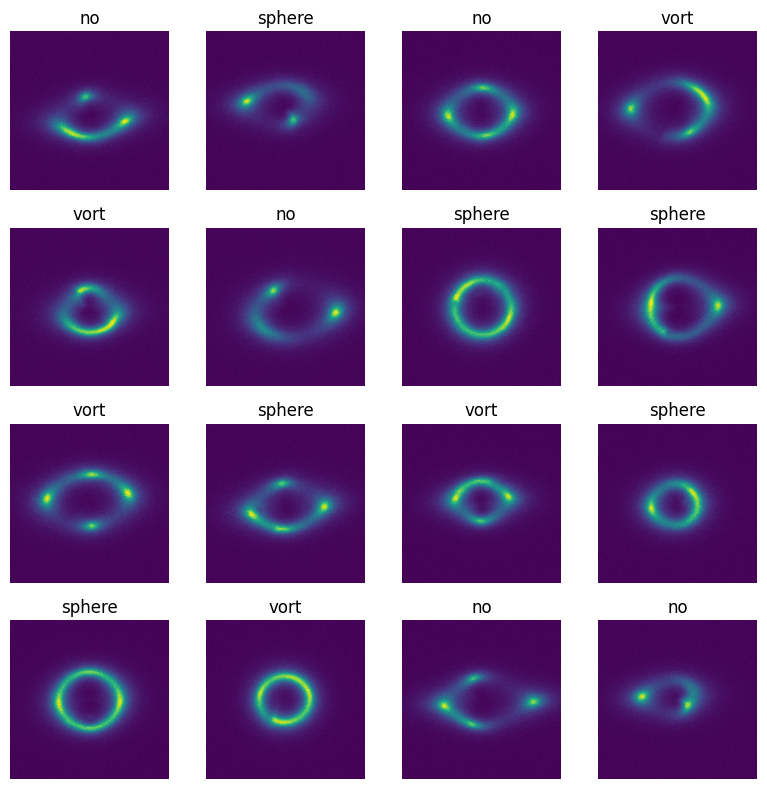

In [3]:
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

# Visualize some images in the train dataset
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    if i < 16:
        image, label = images[i], labels[i]

        img = image.numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(train_dataset.dataset.classes[label])
        ax.axis('off')
    else:
        break

plt.tight_layout()
plt.show()

In [4]:
from transformers import CvtForImageClassification, CvtConfig

config = CvtConfig(
    depth=[1, 2, 6],
    embed_dim=[32, 96, 192],
    id2label={'0': 'no', '1': 'sphere', '2': 'vort'},
    image_size=150,
    label2id={'no': 0, 'sphere': 1, 'vort': 2},
    num_channels=1,
    num_heads=[1, 3, 6],
    num_labels=3
)
model = CvtForImageClassification(config)
model.to(device)

config = model.config
print(config)
model

CvtConfig {
  "attention_drop_rate": [
    0.0,
    0.0,
    0.0
  ],
  "cls_token": [
    false,
    false,
    true
  ],
  "depth": [
    1,
    2,
    6
  ],
  "drop_path_rate": [
    0.0,
    0.0,
    0.1
  ],
  "drop_rate": [
    0.0,
    0.0,
    0.0
  ],
  "embed_dim": [
    32,
    96,
    192
  ],
  "id2label": {
    "0": "no",
    "1": "sphere",
    "2": "vort"
  },
  "image_size": 150,
  "initializer_range": 0.02,
  "kernel_qkv": [
    3,
    3,
    3
  ],
  "label2id": {
    "no": 0,
    "sphere": 1,
    "vort": 2
  },
  "layer_norm_eps": 1e-12,
  "mlp_ratio": [
    4.0,
    4.0,
    4.0
  ],
  "model_type": "cvt",
  "num_channels": 1,
  "num_heads": [
    1,
    3,
    6
  ],
  "padding_kv": [
    1,
    1,
    1
  ],
  "padding_q": [
    1,
    1,
    1
  ],
  "patch_padding": [
    2,
    1,
    1
  ],
  "patch_sizes": [
    7,
    3,
    3
  ],
  "patch_stride": [
    4,
    2,
    2
  ],
  "qkv_bias": [
    true,
    true,
    true
  ],
  "qkv_projection_method": [
   

CvtForImageClassification(
  (cvt): CvtModel(
    (encoder): CvtEncoder(
      (stages): ModuleList(
        (0): CvtStage(
          (embedding): CvtEmbeddings(
            (convolution_embeddings): CvtConvEmbeddings(
              (projection): Conv2d(1, 32, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
              (normalization): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (layers): Sequential(
            (0): CvtLayer(
              (attention): CvtAttention(
                (attention): CvtSelfAttention(
                  (convolution_projection_query): CvtSelfAttentionProjection(
                    (convolution_projection): CvtSelfAttentionConvProjection(
                      (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                      (normalization): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, tra

In [5]:
from transformers import Trainer, TrainingArguments

class Adapter(Dataset):
    def __init__(self, subset):
        self.subset = subset

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        item = self.subset[idx]
        image, label = item
        
        return {'pixel_values': image, 'labels': label}
    
train_dataset_adapter = Adapter(train_dataset)
val_dataset_adapter = Adapter(val_dataset)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=50,
    per_device_train_batch_size=60,
    per_device_eval_batch_size=60,
    warmup_steps=500,
    # weight_decay=0.01,
    # logging_dir='./logs',
    # logging_steps=500,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    seed=42
)

# Define the compute_metrics function for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return load_metric("accuracy").compute(predictions=predictions, references=labels)

# Optimizer & scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-6, eps=1e-1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_adapter,
    eval_dataset=val_dataset_adapter,
    compute_metrics=compute_metrics,
    optimizers = (optimizer, scheduler)
)

In [6]:
# Train the model
trainer.train()

  0%|          | 0/22500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1167523860931396, 'eval_accuracy': 0.333, 'eval_runtime': 14.2549, 'eval_samples_per_second': 210.454, 'eval_steps_per_second': 3.508, 'epoch': 1.0}
{'loss': 1.111, 'learning_rate': 1e-06, 'epoch': 1.11}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1141735315322876, 'eval_accuracy': 0.3293333333333333, 'eval_runtime': 15.2233, 'eval_samples_per_second': 197.066, 'eval_steps_per_second': 3.284, 'epoch': 2.0}
{'loss': 1.1096, 'learning_rate': 1e-06, 'epoch': 2.22}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.113132119178772, 'eval_accuracy': 0.333, 'eval_runtime': 14.4389, 'eval_samples_per_second': 207.772, 'eval_steps_per_second': 3.463, 'epoch': 3.0}
{'loss': 1.1086, 'learning_rate': 1e-06, 'epoch': 3.33}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1118704080581665, 'eval_accuracy': 0.3343333333333333, 'eval_runtime': 14.2735, 'eval_samples_per_second': 210.18, 'eval_steps_per_second': 3.503, 'epoch': 4.0}
{'loss': 1.1069, 'learning_rate': 1e-06, 'epoch': 4.44}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1109510660171509, 'eval_accuracy': 0.3253333333333333, 'eval_runtime': 14.5679, 'eval_samples_per_second': 205.932, 'eval_steps_per_second': 3.432, 'epoch': 5.0}
{'loss': 1.1065, 'learning_rate': 1e-06, 'epoch': 5.56}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1099438667297363, 'eval_accuracy': 0.3253333333333333, 'eval_runtime': 14.3367, 'eval_samples_per_second': 209.253, 'eval_steps_per_second': 3.488, 'epoch': 6.0}
{'loss': 1.1056, 'learning_rate': 1e-06, 'epoch': 6.67}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1094377040863037, 'eval_accuracy': 0.3263333333333333, 'eval_runtime': 14.4976, 'eval_samples_per_second': 206.932, 'eval_steps_per_second': 3.449, 'epoch': 7.0}
{'loss': 1.1051, 'learning_rate': 1e-06, 'epoch': 7.78}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1085094213485718, 'eval_accuracy': 0.32133333333333336, 'eval_runtime': 14.2894, 'eval_samples_per_second': 209.946, 'eval_steps_per_second': 3.499, 'epoch': 8.0}
{'loss': 1.1048, 'learning_rate': 1e-06, 'epoch': 8.89}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1083699464797974, 'eval_accuracy': 0.32266666666666666, 'eval_runtime': 15.1427, 'eval_samples_per_second': 198.116, 'eval_steps_per_second': 3.302, 'epoch': 9.0}
{'loss': 1.1046, 'learning_rate': 1e-06, 'epoch': 10.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1079597473144531, 'eval_accuracy': 0.3233333333333333, 'eval_runtime': 15.255, 'eval_samples_per_second': 196.657, 'eval_steps_per_second': 3.278, 'epoch': 10.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1077848672866821, 'eval_accuracy': 0.3253333333333333, 'eval_runtime': 14.9854, 'eval_samples_per_second': 200.195, 'eval_steps_per_second': 3.337, 'epoch': 11.0}
{'loss': 1.1037, 'learning_rate': 1e-06, 'epoch': 11.11}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.107177972793579, 'eval_accuracy': 0.324, 'eval_runtime': 15.1373, 'eval_samples_per_second': 198.186, 'eval_steps_per_second': 3.303, 'epoch': 12.0}
{'loss': 1.1049, 'learning_rate': 1e-06, 'epoch': 12.22}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1071161031723022, 'eval_accuracy': 0.3243333333333333, 'eval_runtime': 14.8747, 'eval_samples_per_second': 201.685, 'eval_steps_per_second': 3.361, 'epoch': 13.0}
{'loss': 1.1031, 'learning_rate': 1e-06, 'epoch': 13.33}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1069729328155518, 'eval_accuracy': 0.3243333333333333, 'eval_runtime': 15.0274, 'eval_samples_per_second': 199.635, 'eval_steps_per_second': 3.327, 'epoch': 14.0}
{'loss': 1.1036, 'learning_rate': 1e-07, 'epoch': 14.44}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.107081651687622, 'eval_accuracy': 0.32466666666666666, 'eval_runtime': 14.8927, 'eval_samples_per_second': 201.441, 'eval_steps_per_second': 3.357, 'epoch': 15.0}
{'loss': 1.1034, 'learning_rate': 1e-07, 'epoch': 15.56}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1066933870315552, 'eval_accuracy': 0.3273333333333333, 'eval_runtime': 14.7297, 'eval_samples_per_second': 203.671, 'eval_steps_per_second': 3.395, 'epoch': 16.0}
{'loss': 1.1029, 'learning_rate': 1e-07, 'epoch': 16.67}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.106960415840149, 'eval_accuracy': 0.3243333333333333, 'eval_runtime': 15.0015, 'eval_samples_per_second': 199.979, 'eval_steps_per_second': 3.333, 'epoch': 17.0}
{'loss': 1.1038, 'learning_rate': 1e-07, 'epoch': 17.78}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1067101955413818, 'eval_accuracy': 0.326, 'eval_runtime': 14.2145, 'eval_samples_per_second': 211.052, 'eval_steps_per_second': 3.518, 'epoch': 18.0}
{'loss': 1.1033, 'learning_rate': 1e-07, 'epoch': 18.89}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1068518161773682, 'eval_accuracy': 0.32566666666666666, 'eval_runtime': 14.2524, 'eval_samples_per_second': 210.49, 'eval_steps_per_second': 3.508, 'epoch': 19.0}
{'loss': 1.1032, 'learning_rate': 1e-07, 'epoch': 20.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1065006256103516, 'eval_accuracy': 0.326, 'eval_runtime': 14.8435, 'eval_samples_per_second': 202.109, 'eval_steps_per_second': 3.368, 'epoch': 20.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1070725917816162, 'eval_accuracy': 0.3253333333333333, 'eval_runtime': 14.965, 'eval_samples_per_second': 200.468, 'eval_steps_per_second': 3.341, 'epoch': 21.0}
{'loss': 1.1032, 'learning_rate': 1e-08, 'epoch': 21.11}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1067781448364258, 'eval_accuracy': 0.325, 'eval_runtime': 14.3587, 'eval_samples_per_second': 208.933, 'eval_steps_per_second': 3.482, 'epoch': 22.0}
{'loss': 1.1034, 'learning_rate': 1e-08, 'epoch': 22.22}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.106779932975769, 'eval_accuracy': 0.3233333333333333, 'eval_runtime': 45.8262, 'eval_samples_per_second': 65.465, 'eval_steps_per_second': 1.091, 'epoch': 23.0}
{'loss': 1.1035, 'learning_rate': 1e-08, 'epoch': 23.33}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1068065166473389, 'eval_accuracy': 0.3273333333333333, 'eval_runtime': 14.4018, 'eval_samples_per_second': 208.307, 'eval_steps_per_second': 3.472, 'epoch': 24.0}
{'loss': 1.1029, 'learning_rate': 1e-08, 'epoch': 24.44}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1066455841064453, 'eval_accuracy': 0.32566666666666666, 'eval_runtime': 14.4776, 'eval_samples_per_second': 207.217, 'eval_steps_per_second': 3.454, 'epoch': 25.0}
{'loss': 1.1033, 'learning_rate': 1e-08, 'epoch': 25.56}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.106694221496582, 'eval_accuracy': 0.32666666666666666, 'eval_runtime': 14.4114, 'eval_samples_per_second': 208.169, 'eval_steps_per_second': 3.469, 'epoch': 26.0}
{'loss': 1.103, 'learning_rate': 1e-08, 'epoch': 26.67}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1067728996276855, 'eval_accuracy': 0.326, 'eval_runtime': 14.3718, 'eval_samples_per_second': 208.743, 'eval_steps_per_second': 3.479, 'epoch': 27.0}
{'loss': 1.1045, 'learning_rate': 1e-08, 'epoch': 27.78}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1069259643554688, 'eval_accuracy': 0.32466666666666666, 'eval_runtime': 14.2335, 'eval_samples_per_second': 210.77, 'eval_steps_per_second': 3.513, 'epoch': 28.0}
{'loss': 1.1032, 'learning_rate': 1e-08, 'epoch': 28.89}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.106690764427185, 'eval_accuracy': 0.325, 'eval_runtime': 15.0377, 'eval_samples_per_second': 199.499, 'eval_steps_per_second': 3.325, 'epoch': 29.0}
{'loss': 1.1034, 'learning_rate': 1e-08, 'epoch': 30.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1067179441452026, 'eval_accuracy': 0.32566666666666666, 'eval_runtime': 14.123, 'eval_samples_per_second': 212.419, 'eval_steps_per_second': 3.54, 'epoch': 30.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1067650318145752, 'eval_accuracy': 0.32566666666666666, 'eval_runtime': 14.8563, 'eval_samples_per_second': 201.934, 'eval_steps_per_second': 3.366, 'epoch': 31.0}
{'loss': 1.1032, 'learning_rate': 1e-08, 'epoch': 31.11}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1066805124282837, 'eval_accuracy': 0.327, 'eval_runtime': 14.9759, 'eval_samples_per_second': 200.322, 'eval_steps_per_second': 3.339, 'epoch': 32.0}
{'loss': 1.1034, 'learning_rate': 1e-08, 'epoch': 32.22}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1068428754806519, 'eval_accuracy': 0.32666666666666666, 'eval_runtime': 14.8088, 'eval_samples_per_second': 202.582, 'eval_steps_per_second': 3.376, 'epoch': 33.0}
{'loss': 1.1035, 'learning_rate': 1e-08, 'epoch': 33.33}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1067708730697632, 'eval_accuracy': 0.3253333333333333, 'eval_runtime': 14.3967, 'eval_samples_per_second': 208.381, 'eval_steps_per_second': 3.473, 'epoch': 34.0}
{'loss': 1.1034, 'learning_rate': 1e-08, 'epoch': 34.44}


KeyboardInterrupt: 